# First look
Automated first look analysis of single cell RNA-seq data.
- Aim is to use scrna-functions to make a first pass and give an idea of data quality and content.
- We will assume that there has been a little bit of organising, i.e. combining data into one h5ad file with sample and groups in `adata.obs`.
- We will also assume that any metrics metadata will be pointed to, relative to `adata.h5ad`, with a per-sample dictionaryin `adata.uns['metrics_files']`.

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
import seaborn as sns
import matplotlib.pyplot as plt
import scrna_functions as scfunc
import argparse

from fpdf import FPDF
from pdf2image import convert_from_path
from fpdf import FPDF
import dataframe_image as dfi

%load_ext autoreload
%autoreload 2

## User input variables

In [2]:
# where the file is
file_path = Path('/Users/gkennedy/Library/CloudStorage/OneDrive-MalaghanInstituteofMedicalResearch/ongoing/Will_stroma_10x/lane7792/combined_samples_raw.h5ad')

# where to save figures
figs_path = Path('./figures/firstlook/')

# independent samples, e.g. different patients
sample_col = 'sample'

# how samples are grouped, e.g. treatment, condition, disease, etc.
group_col = ''

# use raw data? in case it has been log-normalized already
use_raw = False

In [3]:
# config for QC
max_mt_fraction = 20.
max_top1_fraction = 15.
min_genes = 200
min_cells = 3
pct_outliers_cutoff = 99.

# clustering
n_neighbours = 20
leiden_resolution = 0.8

## For exporting as a script
Add code here to allow export as a script, using argparse to overwrite the user input variables specified above.

In [4]:
"""
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="First look at single-cell RNA-seq data")
    parser.add_argument("--file_path", type=str, default=file_path, help="Path to the input .h5ad file")
    parser.add_argument("--figs_path", type=str, default=figs_path, help="Path to save figures")
    parser.add_argument("--sample_col", type=str, default=sample_col, help="Column name for independent samples")
    parser.add_argument("--group_col", type=str, default=group_col, help="Column name for grouping samples")
    parser.add_argument("--use_raw", action='store_true', default=use_raw, help="Use raw data if set")
    parser.add_argument("--max_mt_fraction", type=float, default=max_mt_fraction, help="Max mitochondrial fraction for QC")
    parser.add_argument("--max_top1_fraction", type=float, default=max_top1_fraction, help="Max top 1 gene fraction for QC")
    parser.add_argument("--min_genes", type=int, default=min_genes, help="Min genes per cell for QC")
    parser.add_argument("--min_cells", type=int, default=min_cells, help="Min cells per gene for QC")
    parser.add_argument("--pct_outliers_cutoff", type=float, default=pct_outliers_cutoff, help="Percentile cutoff for outlier detection")
    parser.add_argument("--n_neighbours", type=int, default=n_neighbours, help="Number of neighbours for clustering")
    parser.add_argument("--leiden_resolution", type=float, default=leiden_resolution, help="Leiden clustering resolution")

    args = parser.parse_args()

    file_path = Path(args.file_path)
    figs_path = Path(args.figs_path)
    sample_col = args.sample_col
    group_col = args.group_col
    use_raw = args.use_raw
    max_mt_fraction = args.max_mt_fraction
    max_top1_fraction = args.max_top1_fraction
    min_genes = args.min_genes
    min_cells = args.min_cells
    pct_outliers_cutoff = args.pct_outliers_cutoff
    n_neighbours = args.n_neighbours
    leiden_resolution = args.leiden_resolution
"""

'\nif __name__ == "__main__":\n    parser = argparse.ArgumentParser(description="First look at single-cell RNA-seq data")\n    parser.add_argument("--file_path", type=str, default=file_path, help="Path to the input .h5ad file")\n    parser.add_argument("--figs_path", type=str, default=figs_path, help="Path to save figures")\n    parser.add_argument("--sample_col", type=str, default=sample_col, help="Column name for independent samples")\n    parser.add_argument("--group_col", type=str, default=group_col, help="Column name for grouping samples")\n    parser.add_argument("--use_raw", action=\'store_true\', default=use_raw, help="Use raw data if set")\n    parser.add_argument("--max_mt_fraction", type=float, default=max_mt_fraction, help="Max mitochondrial fraction for QC")\n    parser.add_argument("--max_top1_fraction", type=float, default=max_top1_fraction, help="Max top 1 gene fraction for QC")\n    parser.add_argument("--min_genes", type=int, default=min_genes, help="Min genes per cel

## Setup

In [5]:
os.makedirs(figs_path, exist_ok=True)

## Read in data

In [6]:
rna = sc.read_h5ad(file_path)

# in case it wasn't already
rna.var_names_make_unique()
rna.obs_names_make_unique()

print(f'reading: {file_path}')
print(rna)

# todo: check if there is also VDJ or other data

reading: /Users/gkennedy/Library/CloudStorage/OneDrive-MalaghanInstituteofMedicalResearch/ongoing/Will_stroma_10x/lane7792/combined_samples_raw.h5ad
AnnData object with n_obs × n_vars = 22968 × 32285
    obs: 'sample', 'Byhand cell type'
    var: 'gene_ids', 'feature_types', 'genome'


In [7]:
if use_raw:
    rna.X = rna.raw.X
else:
    rna.raw = rna.copy()

In [8]:
if 'sample_order' in rna.uns:
    sample_order = rna.uns['sample_order']
else:
    sample_order = sorted(rna.obs[sample_col].unique().tolist())

## Guess whether human or mouse

In [9]:
organism = scfunc.guess_human_or_mouse(rna)
print(f'assuming organism: {organism}')

assuming organism: mouse


## Metrics
Try to use metrics files, otherwise use a few things we know from adata.

In [10]:
if 'metrics_files' in rna.uns:
    metrics = []
    for s, f in rna.uns['metrics_files'].items():
        metrics.append(pd.read_csv(file_path / f))
        metrics[-1]['index'] = s
        # convert to float if possible
        for c in metrics[-1].columns:
            try:
                metrics[-1][c] = metrics[-1][c].str.replace(',', '', regex=False).str.replace('%', '', regex=False).astype(float)
            except:
                pass

    metrics = pd.concat(metrics)
    metrics['index'] = metrics['index'].str.split('/')
    metrics['index'] = list(map(lambda x: x[-2], metrics['index']))
    metrics.set_index('index', inplace=True)

    keep_cols = ['Estimated Number of Cells', 'Mean Reads per Cell', 'Median Genes per Cell', 'Total Genes Detected',
                'Valid Barcodes', 'Reads Mapped Confidently to Genome', 'Sequencing Saturation']

    metrics_table = metrics[keep_cols].T

    # samples with a) low cells or b) low reads
    fig, ax = plt.subplots()  # Adjust the figure size if necessary
    sns.scatterplot(metrics, x='Estimated Number of Cells', y='Mean Reads per Cell', size='Median Genes per Cell',
                    hue=metrics.index, legend=True, ax=ax)

    ax.set_xscale('log')
    ax.set_yscale('log')

    # Position the legend outside the plot to the right
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    fig.tight_layout()
    fig.savefig(str(figs_path / 'metrics_scatter.png'))
else:
    metrics_table = pd.DataFrame({'sample': sample_order, 
                                  'Estimated Number of Cells': rna.obs[sample_col].value_counts().reindex(sample_order).values,
                                  'Total Genes Detected': [rna[rna.obs[sample_col] == s].n_vars for s in sample_order]})
    metrics_table.set_index('sample', inplace=True)
    metrics_table = metrics_table.T

## Quality control

In [11]:
scfunc.filter_cells_genes(rna)
scfunc.compute_qc_metrics(rna)

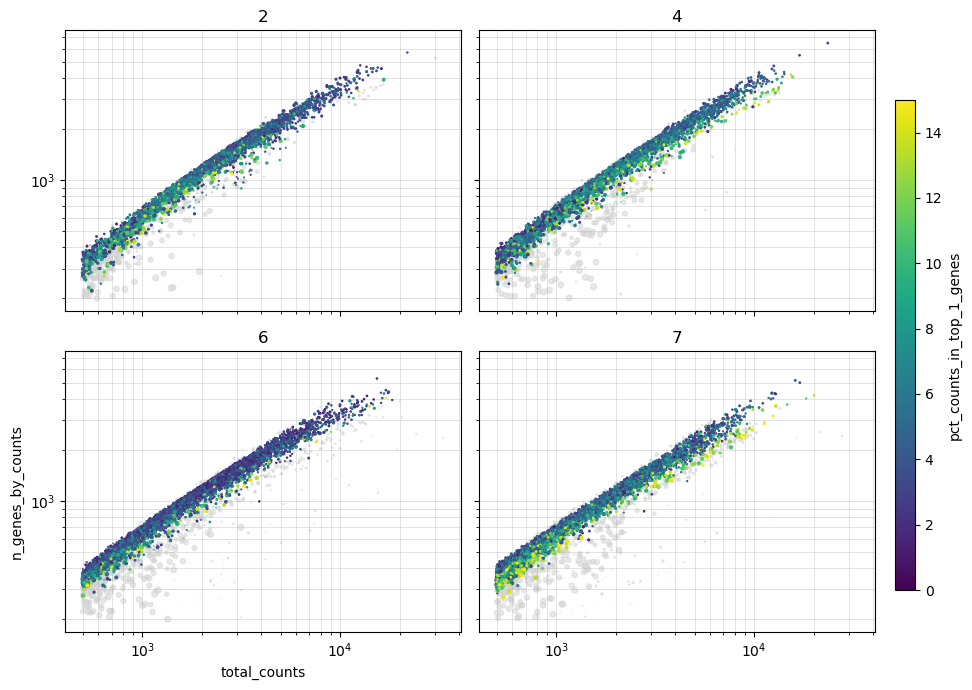

In [12]:
mask = scfunc.trim_outliers(rna, groupby=sample_col,
                            extra_mask={'pct_counts_mt': [max_mt_fraction, 'max'],
                                        'pct_counts_in_top_1_genes': [max_top1_fraction, 'max']},
                            pct=pct_outliers_cutoff,
                            )

fig = scfunc.plot_gene_counts(rna, hue=sample_col, order=sample_order, mask=mask, show_masked=True)
fig.savefig(str(figs_path / 'gene_counts_per_sample.pdf'))

In [13]:
# apply mask
rna = rna[mask, :].copy()

## Doublets

In [14]:
sc.pp.scrublet(rna, batch_key=sample_col)

## Cell cycle

In [15]:
cell_cycle_genes = scfunc.get_cell_cycle_genes(organism, gene_list=rna.var_names)
sc.tl.score_genes_cell_cycle(rna, s_genes=cell_cycle_genes['s_genes'], g2m_genes=cell_cycle_genes['g2m_genes'])

Missing S phase genes: ['Mlf1ip']
Missing G2M phase genes: ['Fam64a', 'Hn1']


## UMAPs

In [16]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna)

# sc.pp.scale(rna, zero_center=False)
sc.tl.pca(rna)

# batch correction using Harmony
sc.external.pp.harmony_integrate(rna, key=sample_col)

2025-09-16 16:32:27,725 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-16 16:32:27 | [INFO] Computing initial centroids with sklearn.KMeans...
2025-09-16 16:32:31,795 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-16 16:32:31 | [INFO] sklearn.KMeans initialization complete.
2025-09-16 16:32:31,853 - harmonypy - INFO - Iteration 1 of 10
2025-09-16 16:32:31 | [INFO] Iteration 1 of 10
2025-09-16 16:32:41,859 - harmonypy - INFO - Iteration 2 of 10
2025-09-16 16:32:41 | [INFO] Iteration 2 of 10
2025-09-16 16:32:43,443 - harmonypy - INFO - Iteration 3 of 10
2025-09-16 16:32:43 | [INFO] Iteration 3 of 10
2025-09-16 16:32:45,036 - harmonypy - INFO - Iteration 4 of 10
2025-09-16 16:32:45 | [INFO] Iteration 4 of 10
2025-09-16 16:32:45,985 - harmonypy - INFO - Iteration 5 of 10
2025-09-16 16:32:45 | [INFO] Iteration 5 of 10
2025-09-16 16:32:46,628 - harmonypy - INFO - Iteration 6 of 10
2025-09-16 16:32:46 | [INFO] Iteration 6 of 10
2025-09-16

In [17]:
sc.pp.neighbors(rna, n_neighbors=n_neighbours, use_rep="X_pca_harmony")
sc.tl.umap(rna, random_state=42)  # Compute UMAP
sc.tl.leiden(rna, resolution=leiden_resolution)

... storing 'sample' as categorical
... storing 'phase' as categorical


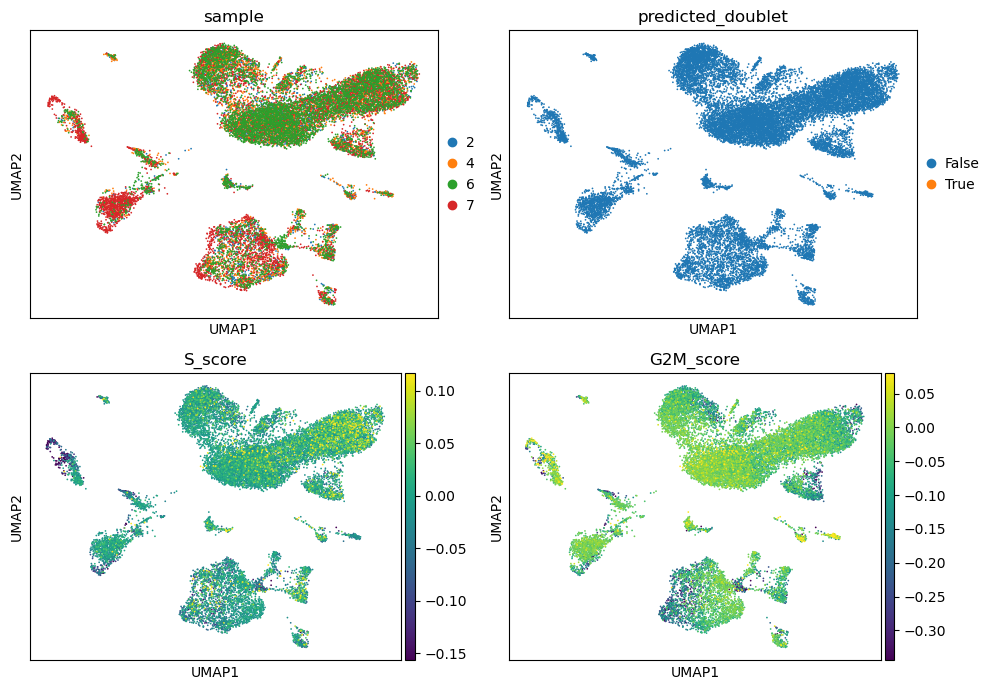

In [18]:
fig , ax = plt.subplots(2, 2, figsize=(10,7))
for i, x in enumerate(zip([sample_col, 'predicted_doublet', 'S_score', 'G2M_score'],
                          [False, False, True, True])):
    col, vminmax = x
    vmin, vmax = None, None
    if vminmax:
        vmin, vmax = np.percentile(rna.obs[col], (1, 99))
    sc.pl.umap(rna, color=col, vmin=vmin, vmax=vmax,
               ax=ax[i//2, i%2], show=False)
fig.tight_layout()
fig.savefig(str(figs_path / 'umap_overview.pdf'))

## cell types

### decoupler/PanglaoDB

In [19]:
# decoupler
markers = dc.op.resource("PanglaoDB", organism=organism)

# Filter by canonical_marker and human
markers = markers[
    markers[organism].astype(bool)
    & markers["canonical_marker"].astype(bool)
    & (markers[f"{organism}_sensitivity"].astype(float) > 0.5)
]

# Remove duplicated entries
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]

# Format
markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target", f"{organism}_sensitivity": "weight"})
markers = markers[["source", "target", "weight"]]

dc.mt.ulm(rna, markers, verbose=False)
score = dc.pp.get_obsm(rna, key="score_ulm")
df = dc.tl.rankby_group(adata=score, groupby="leiden", reference="rest", method="t-test_overestim_var")
df = df[df["stat"] > 0]
dict_ann = df[df["stat"] > 0].groupby("group").head(1).set_index("group")["name"].to_dict()
rna.obs['celltype_panglao'] = rna.obs["leiden"].map(dict_ann)

### celltypist

In [20]:
scfunc.celltypist_annotate_immune(rna)

2025-09-16 16:33:17 | [INFO] 🔬 Input data has 19327 cells and 20307 genes
2025-09-16 16:33:17 | [INFO] 🔗 Matching reference genes in the model
2025-09-16 16:33:17 | [INFO] 🧬 4543 features used for prediction
2025-09-16 16:33:17 | [INFO] ⚖️ Scaling input data
2025-09-16 16:33:18 | [INFO] 🖋️ Predicting labels
2025-09-16 16:33:18 | [INFO] ✅ Prediction done!
2025-09-16 16:33:18 | [INFO] 👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
2025-09-16 16:33:18 | [INFO] ⛓️ Over-clustering input data with resolution set to 10
2025-09-16 16:33:18 | [INFO] 🗳️ Majority voting the predictions
2025-09-16 16:33:18 | [INFO] ✅ Majority voting done!
2025-09-16 16:33:18 | [INFO] 🔬 Input data has 19327 cells and 20307 genes
2025-09-16 16:33:18 | [INFO] 🔗 Matching reference genes in the model
2025-09-16 16:33:19 | [INFO] 🧬 4543 features used for prediction
2025-09-16 16:33:19 | [INFO] ⚖️ Scaling input data
2025-09-16 16:33:19 | [INFO] 🖋️ Predicting labels
2025-0

### more umaps

... storing 'celltype_panglao' as categorical


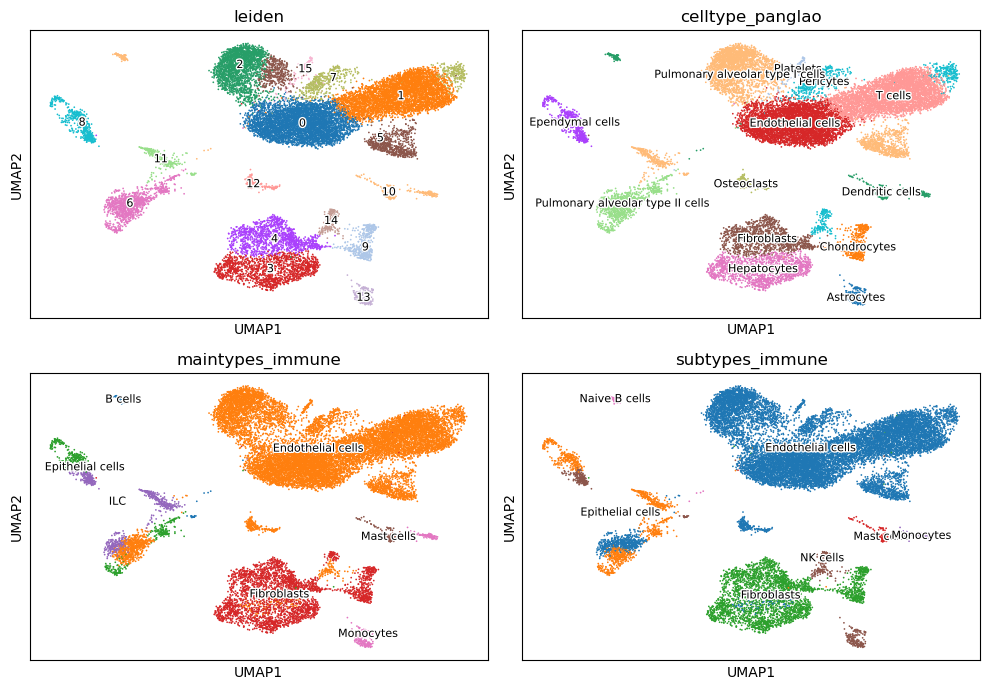

In [21]:
fig , ax = plt.subplots(2, 2, figsize=(10,7))
for i, x in enumerate(zip(['leiden', 'celltype_panglao', 'maintypes_immune', 'subtypes_immune'],
                          [True, True, True, True])):
    col, show_legend = x
    sc.pl.umap(rna, color=col, ncols=2,
               legend_loc='on data' if show_legend else True, legend_fontsize=8, legend_fontoutline=2, legend_fontweight='normal',
               ax=ax[i//2, i%2], show=False)
fig.tight_layout()
fig.savefig(str(figs_path / 'umap_celltypes.pdf'))

## Generate summary
Use fpdf2 to make a report with four panels on an a4 page
- top left: metrics table
- bottom left: gene_counts_per_sample.pdf
- top right: umap_overview.pdf
- bottom right: umap_celltypes.pdf

In [22]:
# Save metrics_table as an image
metrics_img_path = figs_path / "metrics_table.png"
with open(metrics_img_path, 'wb') as f:
    dfi.export(metrics_table, f)  # may have to watch for errors if used as a script

# Prepare file paths for images
gene_counts_img = figs_path / "gene_counts_per_sample.pdf"
umap_overview_img = figs_path / "umap_overview.pdf"
umap_celltypes_img = figs_path / "umap_celltypes.pdf"

# Convert PDFs to PNGs for FPDF (if needed)
def pdf_to_png(pdf_path, out_path):
    images = convert_from_path(str(pdf_path), dpi=150)
    images[0].save(out_path, 'PNG')

gene_counts_png = figs_path / "gene_counts_per_sample.png"
umap_overview_png = figs_path / "umap_overview.png"
umap_celltypes_png = figs_path / "umap_celltypes.png"

pdf_to_png(gene_counts_img, gene_counts_png)
pdf_to_png(umap_overview_img, umap_overview_png)
pdf_to_png(umap_celltypes_img, umap_celltypes_png)

# Create PDF report
pdf = FPDF(orientation='L', unit='mm', format='A4')
pdf.add_page()

page_w, page_h = pdf.w, pdf.h
margin_x, margin_y = 1, 1

# Add title and subtitle to the PDF page
title = file_path.name
subtitle = str(file_path.resolve())

pdf.set_font("Helvetica", "", 10)
pdf.set_x(margin_x)
pdf.cell(page_w - 2 * margin_x, 2, subtitle, align="C", new_y='NEXT')
title_h = pdf.get_y() + 2

# Panel positions and sizes
panel_w, panel_h = (page_w - 2 * margin_x) / 2, (page_h - 2 * margin_y - title_h) / 2

pdf.image(str(metrics_img_path), x=margin_x, y=margin_y + title_h)#, w=panel_w, h=panel_h)
pdf.image(str(gene_counts_png), x=margin_x, y=margin_y + title_h + panel_h, w=panel_w, h=panel_h)
pdf.image(str(umap_overview_png), x=margin_x + panel_w, y=margin_y + title_h, w=panel_w, h=panel_h)
pdf.image(str(umap_celltypes_png), x=margin_x + panel_w, y=margin_y + panel_h + title_h, w=panel_w, h=panel_h)

report_path = figs_path / "firstlook_report.pdf"
pdf.output(str(report_path))
print(f"Report saved to {report_path}")

16937 bytes written to file /var/folders/mg/0dy5ly3x2196rs28xt2by2zm0000gq/T/tmpf8an6aus/temp.png


Report saved to figures/firstlook/firstlook_report.pdf


In [23]:
rna

AnnData object with n_obs × n_vars = 19327 × 20307
    obs: 'sample', 'Byhand cell type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_malat', 'pct_counts_malat', 'pct_counts_in_top_1_genes', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype_panglao', 'maintypes_predicted_labels', 'maintypes_over_clustering', 'maintypes_immune', 'maintypes_conf_score', 'subtypes_predicted_labels', 'subtypes_over_clustering', 'subtypes_immune', 'subtypes_conf_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribosomal', 'malat', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'filter_cells_genes', 'pct_counts', 'trim_outliers_mask', 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'sample_colors', 'predicted_doublet_colors',